To DO: 
- Consider lemmatizing using Stanford lemmatizer
- Understand how to get 'Satoshi Words' in an unbiased manner
- Methodology: reduce to list of descriminiating words. 
- See if can get good chisq p-vals (perhaps chisq is biased on this set)


In [1]:
%load_ext autoreload
import os
import re
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('/Users/kipnisal/Documents/Authorship/')

from AuthAttLib import *
from visualize_HC_scores import *

import pickle

from load_problem_data import *

<H2> Preprocess Data (only run once)</H2>

In [4]:
# optional: remove proper names, cardinal digits, and punctuation
from text_processing import remove_parts_of_speach
punct = [':',';','"','(',')','-',',','.','`','\`']

def text_proc_loc(text) :
    return remove_parts_of_speach(text, to_remove = ['NNP', 'NNPS', 'CD'])

def lemmatize_list(list_of_words) :
    return list(set(remove_parts_of_speach(" ".join(list_of_words), to_remove=[]).split()))


In [5]:
data = load_problem_data("/Users/kipnisal/Dropbox/WhoIsSatoshi/")

data_proc = data.copy()
    
data_proc.text = data.text.astype(str).apply(text_proc_loc)
data_proc.to_csv('data_proc.csv')

100%|██████████| 14/14 [01:02<00:00,  5.11s/it]


<H3>External Data</H3>

In [35]:
#load external data
PAN19 = load_problem_data("/Users/kipnisal/Data/PAN/pan19-cross-domain-authorship-attribution-training-dataset-2019-01-23/")
PAN18 = load_problem_data("/Users/kipnisal/Data/PAN/pan18-cross-domain-authorship-attribution-test-dataset2-2018-04-20/")

PAN19 = PAN19[PAN19.author.isin(['problem0000{}'.format(i+1) for i in range(5)])]
PAN19 = PAN19[PAN19.type != 'unknown']
PAN19.loc[:,'author'] = PAN19.author + PAN19.loc[:,'type']
PAN19.loc[:,'type'] = 'PAN19'

PAN18 = PAN18[PAN18.author.isin(['problem0000{}'.format(i+1) for i in range(4)])]
PAN18 = PAN18[PAN18.type != 'unknown']
PAN18.loc[:,'author'] = PAN18.author + PAN18.loc[:,'type']
PAN18.loc[:,'type'] = 'PAN18'

100%|██████████| 20/20 [00:07<00:00,  2.25it/s]


<H2>Arrange Data</H2>

In [5]:
INCLUDE_TECHNICAL = False
#arrange Staoshi's documents by topics
data_proc = pd.read_csv('data.csv')

# aggreagte emails and technical forum posts
satoshi_emails = data_proc[(data_proc.author == 'Satoshi') # merge all Staoshi's emails
                         & (data_proc['type'] == 'email')].text.astype(str).agg(sum)
satoshi_forum = data_proc[(data_proc.author == 'Satoshi') # merge all Staoshi's forum posts
                          & (data_proc['type'] == 'technical (forum)')].text.astype(str).agg(sum)

data_proc = data_proc[~((data_proc.author == 'Satoshi') # merge all Staoshi's forum posts
                          & data_proc['type'].isin(['technical (forum)', 'email']))]

if INCLUDE_TECHNICAL :
    data_proc = data_proc.append({'doc_id' : 'Satoshi_emails',
                    'text' : satoshi_emails,
                    'author' : 'Satoshi',
                    'type' : 'emails'}, ignore_index = True)
    data_proc = data_proc.append({'doc_id' : 'Satoshi_forum',
                    'text' : satoshi_forum,
                    'author' : 'Satoshi',
                    'type' : 'technical (forum)'},ignore_index = True)

In [5]:
#add external data
data_proc = data_proc.append(PAN18).append(PAN19).filter(['author','doc_id','text','type'])

<H2>Using a preset Dictionary</H2>

In [6]:
#load preset vocabulary
from text_processing import *
vocab5000_df = pd.read_csv('~/Data/5000 most common english words.csv')
vocab5000 = lemmatize_list(vocab5000_df.Word) # to remove dublicate terms

In [ ]:
#load pretrained model
path = ''
desc = "external_data"
model = pickle.load( open(path + "multi_w{}_{}.pkl".format(len(vocab),desc), "rb") )

In [5]:
data_proc = pd.read_csv('data_proc.csv')

In [9]:
function_words1 =  ['a','as','do','has','is','no','or','than','this','when',
  'all','at','down','have','it','not','our','that','to','which',
  'also','be','even','her','its','now','shall','the','up','who',
  'an','been','every','his','may','of','should','their','upon','will',
  'and','but','for','if','more','on','so','then','was','with',
  'any','by','from','in','must','one','some','there','were','would',
  'are','can','had','into','my','only','such','thing','what','your']

# two list of additional words used by Mosteller & Wallace
additional_words1 = ['affect','city','direction','innovation','perhaps','vigor',
                    'again','commonly','disgracing','join','rapid','violate','although',
                    'consequently','either','language','sarne','violence','among','considerable',
                    'enough','most','second','voice','another','contribute','nor','still',
                    'where','because','defensive','fortune','offensive','those','whether',
                    'between','destruction','function','often','throughout', 'while','both',
                    'did','himself','pass','under','whilst']

additional_words2 = ['about','choice','proper','according','common','kind','propriety','adversaries',
                    'danger','large','provision','after','decide','decides','decided','deciding',
                    'likely','requiisite','aid','degree','matters','matter','substance','always',
                    'during','moreover','they','apt','expence','expences','necessary','though',
                    'asserted','expenses','expense','necessity','necessities','truth','truths',
                    'before','extent','others','us','being','follows','follow','particularly',
                    'usages','usage','better','I','principle','we','care','imagine','edit','editing',
                    'probability','work']


words_to_ignore = ['27', 'https', 'typekit','subset_id','cid',
                    'fvd','af','n7', 'opentype','woff2','woff','tk',
                  '50','12','http','10','sinc','www','site','mso','com',
                   'af','font','src','url','proxima','color','microsoft','hal',
                  'san','craig','wright','satoshi','vili','lehdonvirta',
                  'bick', 'szabo', 'body', 'sans','%','ded','fb', 'php',' ',
                  'badb','fdb','fa', 'table', 'nav', 'linux', 'div', 
                   'saved', 'bitcoin','unix','text', 'xi',
                    'ad', 'pp', 'a', 'px', 'db', 'var', 'function', 
                   'format', 'weight', 'style', 'family', 'content', 'castronova',
                   'buttonize','net','th','kudo','activate','figure',
                   'pro','tree', 'user','disk','href'
                  ] 

punct = [':',';','"','(',')','-',',','.','`','\`','%','&']


function_words = lemmatize_list(function_words1 + additional_words1 + additional_words2)

In [19]:
#train model

ds = data_proc
ds = ds[~ds['type'].isin(['technical'])]
#ds = ds[~((ds.author == 'Satoshi') & (ds.type.isin(['emails', 'technical (forum)'])))]
ds = ds.filter(['doc_id','text','author','type'])

ds = ds.dropna()

VOCAB_SIZE = 500

model = AuthorshipAttributionMulti(ds,
                                   vocab = vocab5000[:VOCAB_SIZE],
                              vocab_size = VOCAB_SIZE,
                              ngram_range = (1,3),
                            words_to_ignore = words_to_ignore + punct,
                              stbl = True)

#desc = "external_data"

pickle.dump(model,open("multi_{}.pkl".format(desc), "wb" ))


# get results wrt Satoshi:
df0 = model.internal_stats_corpus()
df_satoshi = df0[(df0.author == 'Satoshi') | (df0.wrt_author == 'Satoshi')]
df_satoshi.loc[df_satoshi.author == 'Satoshi', 'author'] = df_satoshi.loc[df_satoshi.author == 'Satoshi','wrt_author']
df_satoshi.loc[:,'wrt_author'] = 'Satoshi'

	 Creating author-model for Wright-Kleiman using 500 features...
		found 1 documents and 161 relevant tokens.
	 Creating author-model for Others using 500 features...
		found 3 documents and 649 relevant tokens.
	 Creating author-model for Grover using 500 features...
		found 5 documents and 184 relevant tokens.
	 Creating author-model for Hal Finney using 500 features...
		found 13 documents and 566 relevant tokens.
	 Creating author-model for Albert Eistein using 500 features...
		found 1 documents and 1471 relevant tokens.
	 Creating author-model for Vili Lehdonvirta using 500 features...
		found 8 documents and 5785 relevant tokens.
	 Creating author-model for Satoshi using 500 features...
		found 75 documents and 846 relevant tokens.
	 Creating author-model for Kleiman using 500 features...
		found 1 documents and 15872 relevant tokens.
	 Creating author-model for Gavin Andresen using 500 features...
		found 22 documents and 3379 relevant tokens.
	 Creating author-model for Thomas

  0%|          | 0/14 [00:00<?, ?it/s]

		found 23 documents and 2644 relevant tokens.


/Users/kipnisal/Documents/Authorship/utils.py:34: RuntimeWarning: divide by zero encountered in log
  return chisq - dof, np.log(pval)
 43%|████▎     | 6/14 [00:02<00:03,  2.04it/s]/Users/kipnisal/Documents/Authorship/DocTermTable.py:378: RuntimeWarning: invalid value encountered in less
  s = np.sum(np.array(lo_hc) < HC)
100%|██████████| 14/14 [00:08<00:00,  1.14it/s]
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
df_satoshi.loc[df_satoshi.HC.sort_values().index,:]

,HC,HC_rank,author,chisq,chisq_pval,cosine,feat,no_docs (author),no_docs (wrt_author),no_tokens (author),wrt_author
33,3.182951,0.973684,Wright-Kleiman,311.583748,-79.163720,0.655055,"[maximum, you, high, original, actually, court...",1.0,75.0,161.0,Satoshi
8,3.276224,0.833333,Grover,186.366637,-38.914291,0.148568,"[out, short, before, investment, financial, ne...",75.0,5.0,846.0,Satoshi
63,4.876168,0.875000,Control,247.567132,-53.390954,0.169323,"[slightly, out, short, what, well, water, befo...",75.0,7.0,846.0,Satoshi
15,5.181578,0.928571,Hal Finney,263.103017,-54.993306,0.163858,"[political, rest, you, calculate, who, might, ...",75.0,13.0,846.0,Satoshi
35,5.837482,0.973684,Thomas Meyer,635.988657,-201.786130,0.910991,"[case, extreme, out, you, act, involved, well,...",2.0,75.0,301.0,Satoshi
39,6.182749,0.500000,Kleiman,942.637682,-252.828613,0.100976,"[medium, current, space, case, combined, tray,...",75.0,1.0,846.0,Satoshi
56,6.364671,0.965517,Nick Szabo,1824.804506,-607.986263,0.556058,"[medium, tray, find, boot, rest, physical, you...",75.0,28.0,846.0,Satoshi
86,6.637249,0.958333,Craig Wright,659.492250,-176.424830,0.318812,"[excellent, medium, maximum, benefit, case, co...",75.0,23.0,846.0,Satoshi
34,6.719360,0.973684,Vili Lehdonvirta,2495.995943,-inf,0.675561,"[medium, current, space, tray, find, boot, res...",8.0,75.0,5785.0,Satoshi
2,7.230220,0.750000,Others,724.448711,-235.605180,0.713853,"[case, pro, find, out, you, who, constraint, w...",75.0,3.0,846.0,Satoshi


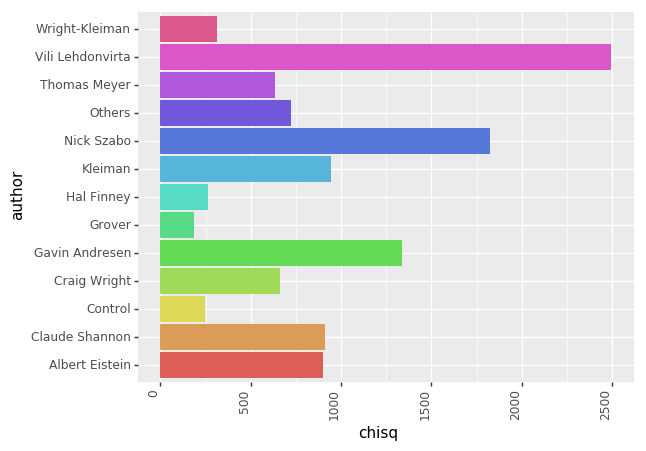

<ggplot: (297026806)>


In [21]:
from plotnine import *
import matplotlib.colors as mcolors

ix = df_satoshi.reset_index().sort_values('HC').index.tolist()

p = (ggplot(aes(x = 'author', y = 'chisq', fill = 'author'), data = df_satoshi) 
     + geom_col(show_legend = False) + theme(axis_text_x=element_text(rotation=90, hjust=1)) 
  #  + scale_x_discrete(limits=ix)
     + coord_flip()
    )
print(p)
#p.save("HC_wrt_satoshi.png",height = 4, width = 15)


In [18]:
#scores wrt Satoshi
df = model.internal_stats(wrt_authors=['Craig Wright', 'Hal Finney', 'Nick Szabo','Grover'], LOO = False)

  0%|          | 0/4 [00:00<?, ?it/s]/Users/kipnisal/Documents/Authorship/utils.py:34: RuntimeWarning: divide by zero encountered in log
  return chisq - dof, np.log(pval)



ValueError: seems like all counts are zero. Did you pass the wrong data format?

In [84]:
labels = ('Craig Wright', 'Nick Szabo', 'Hal Finney', 'Grover')
df = model.internal_stats(wrt_authors=labels, LOO = False)

100%|██████████| 4/4 [00:42<00:00, 10.69s/it]


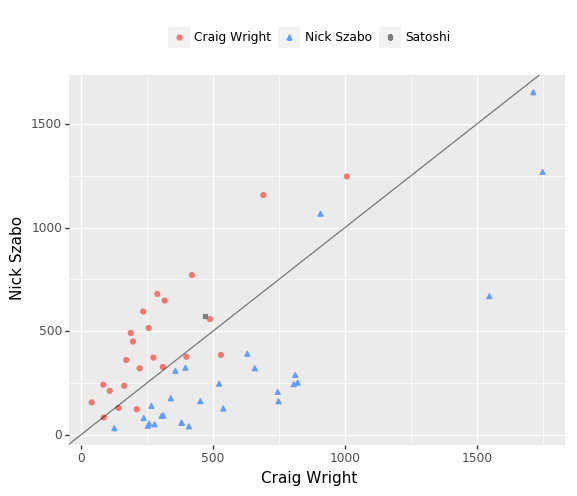

<ggplot: (-9223372036544224866)>


/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.7/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


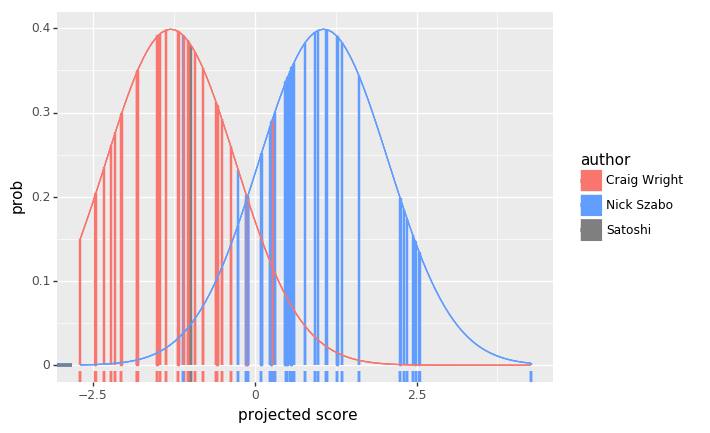

<ggplot: (-9223372036543809406)>


In [78]:
wrt_authors = ['Craig Wright', 'Nick Szabo']
p = plot_author_pair(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'chisq',  wrt_authors = wrt_authors)
print(p)
p = plot_LDA(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'chisq',  wrt_authors = wrt_authors)
print(p)

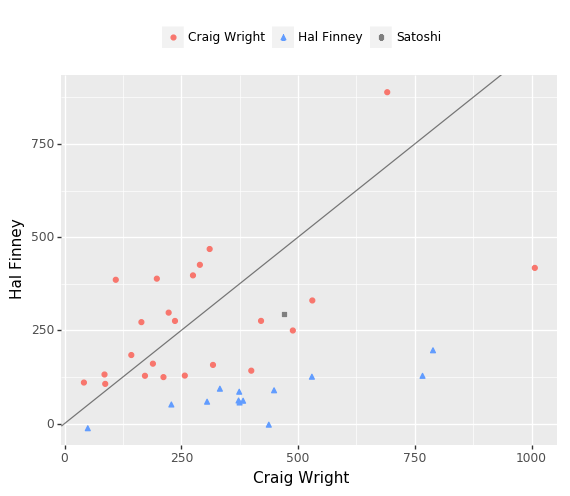

<ggplot: (311263194)>


/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.7/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


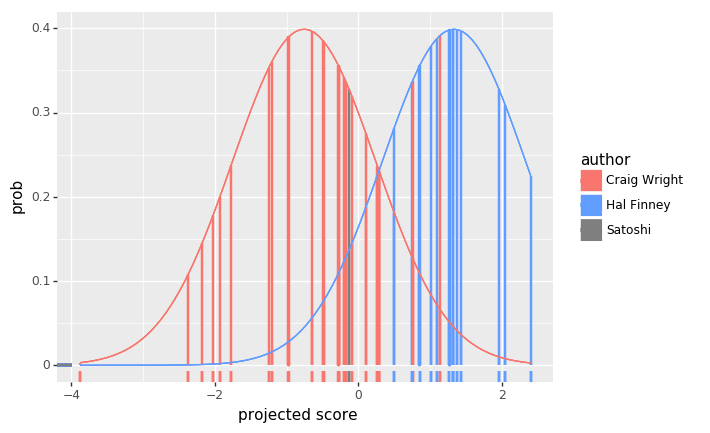

<ggplot: (310919053)>


In [79]:
wrt_authors = ['Craig Wright', 'Hal Finney']
p = plot_author_pair(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'chisq',  wrt_authors = wrt_authors)
print(p)
p = plot_LDA(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'chisq',  wrt_authors = wrt_authors)
print(p)

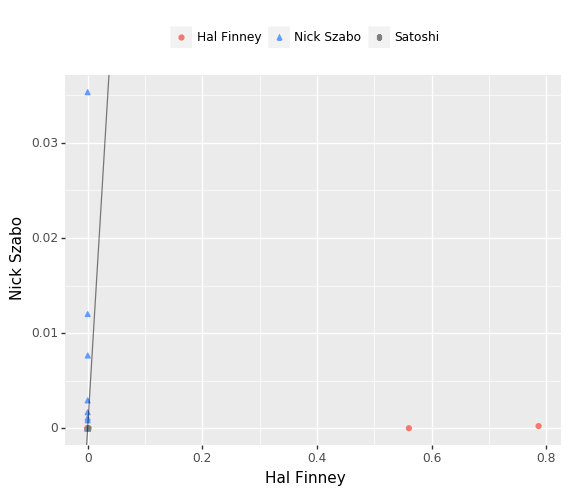

<ggplot: (-9223372036541699198)>


/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.7/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


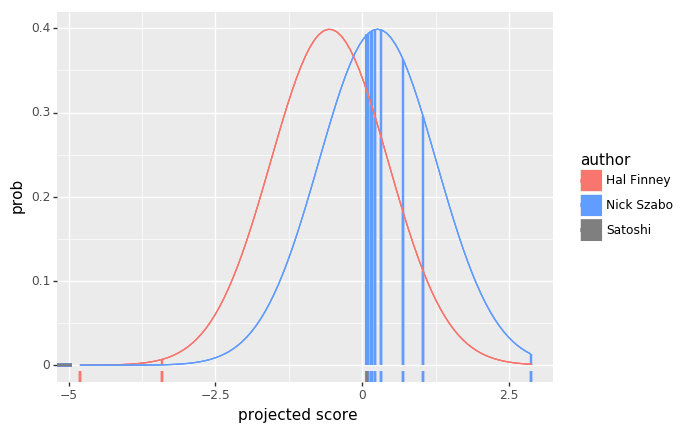

<ggplot: (301927260)>


In [81]:
wrt_authors = ['Hal Finney', 'Nick Szabo']
p = plot_author_pair(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'chisq',  wrt_authors = wrt_authors)
print(p)

p = plot_LDA(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'chisq',  wrt_authors = wrt_authors)
print(p)

In [61]:
ds.loc[ds.text.isna().idxmax(),:]

Unnamed: 0                                                   81
doc_id        Bitcoin Faucet changes _ Satoshi Nakamoto Inst...
text                                                        NaN
author                                                  Satoshi
type                                                      email
Name: 81, dtype: object

In [75]:
# TODO: only use list of finalists

ds = data_proc
ds = ds[~ds['type'].isin(['technical','email'])]
#ds = ds[~((ds.author == 'Satoshi') & (ds.type.isin(['emails', 'technical (forum)'])))]

model_binary = AuthorshipAttributionMultiBinary(ds,
                                         vocab = function_words,
                                         reduce_features=True
                                        )

Found 66 author-pairs
MultiBinaryAuthorModel: Creating model for Grover vs Wright-Kleiman...
	 Creating author-model for Wright-Kleiman using 169 features...
		found 1 documents and 2424 relevant tokens.
	 Creating author-model for Grover using 169 features...
		found 5 documents and 1323 relevant tokens.
Changing vocabulary for Wright-Kleiman. Found 1847 relevant tokens.
Changing vocabulary for Grover. Found 996 relevant tokens.
Reduced to 38 features...
MultiBinaryAuthorModel: Creating model for Grover vs Hal Finney...
	 Creating author-model for Grover using 169 features...
		found 5 documents and 1323 relevant tokens.
	 Creating author-model for Hal Finney using 169 features...
		found 13 documents and 5349 relevant tokens.
Changing vocabulary for Grover. Found 798 relevant tokens.
Changing vocabulary for Hal Finney. Found 3154 relevant tokens.
Reduced to 39 features...
MultiBinaryAuthorModel: Creating model for Grover vs Vili Lehdonvirta...
	 Creating author-model for Grover using

		found 28 documents and 48801 relevant tokens.
Changing vocabulary for Albert Eistein. Found 13420 relevant tokens.
Changing vocabulary for Nick Szabo. Found 37712 relevant tokens.
Reduced to 69 features...
MultiBinaryAuthorModel: Creating model for Albert Eistein vs Control...
	 Creating author-model for Albert Eistein using 169 features...
		found 1 documents and 17116 relevant tokens.
	 Creating author-model for Control using 169 features...
		found 14 documents and 4640 relevant tokens.
Changing vocabulary for Albert Eistein. Found 12679 relevant tokens.
Changing vocabulary for Control. Found 3524 relevant tokens.
Reduced to 60 features...
MultiBinaryAuthorModel: Creating model for Albert Eistein vs Claude Shannon...
	 Creating author-model for Albert Eistein using 169 features...
		found 1 documents and 17116 relevant tokens.
	 Creating author-model for Claude Shannon using 169 features...
		found 1 documents and 11162 relevant tokens.
Changing vocabulary for Albert Eistein. Foun

Changing vocabulary for Nick Szabo. Found 33882 relevant tokens.
Reduced to 46 features...
MultiBinaryAuthorModel: Creating model for Nick Szabo vs Vili Lehdonvirta...
	 Creating author-model for Vili Lehdonvirta using 169 features...
		found 8 documents and 45656 relevant tokens.
	 Creating author-model for Nick Szabo using 169 features...
		found 28 documents and 48801 relevant tokens.
Changing vocabulary for Vili Lehdonvirta. Found 29596 relevant tokens.
Changing vocabulary for Nick Szabo. Found 31502 relevant tokens.
Reduced to 66 features...
MultiBinaryAuthorModel: Creating model for Nick Szabo vs Satoshi...
	 Creating author-model for Satoshi using 169 features...
		found 39 documents and 3704 relevant tokens.
	 Creating author-model for Nick Szabo using 169 features...
		found 28 documents and 48801 relevant tokens.
Changing vocabulary for Satoshi. Found 1817 relevant tokens.
Changing vocabulary for Nick Szabo. Found 23104 relevant tokens.
Reduced to 51 features...
MultiBinaryAu

		found 28 documents and 48801 relevant tokens.
	 Creating author-model for Claude Shannon using 169 features...
		found 1 documents and 11162 relevant tokens.
Changing vocabulary for Nick Szabo. Found 29227 relevant tokens.
Changing vocabulary for Claude Shannon. Found 6730 relevant tokens.
Reduced to 62 features...
MultiBinaryAuthorModel: Creating model for Claude Shannon vs Control...
	 Creating author-model for Control using 169 features...
		found 14 documents and 4640 relevant tokens.
	 Creating author-model for Claude Shannon using 169 features...
		found 1 documents and 11162 relevant tokens.
Changing vocabulary for Control. Found 3658 relevant tokens.
Changing vocabulary for Claude Shannon. Found 8910 relevant tokens.
Reduced to 65 features...
MultiBinaryAuthorModel: Creating model for Claude Shannon vs Craig Wright...
	 Creating author-model for Claude Shannon using 169 features...
		found 1 documents and 11162 relevant tokens.
	 Creating author-model for Craig Wright using 1

In [76]:
df1 = model_binary.predict_stats(ds[ds.doc_id == 'Bitcoin_whitepaper.txt'].text.values[0])
df1.pred.value_counts()

In [72]:
df1.pred.value_counts()

Satoshi             11
Hal Finney           9
Wright-Kleiman       9
Albert Eistein       8
Claude Shannon       6
Craig Wright         6
Kleiman              6
Control              5
Vili Lehdonvirta     3
Gavin Andresen       1
Grover               1
Nick Szabo           1
Name: pred, dtype: int64

In [82]:
wrt_authors = ['Hal Finney', 'Grover']
p = plot_author_pair(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'chisq',  wrt_authors = wrt_authors)
print(p)

p = plot_LDA(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'chisq',  wrt_authors = wrt_authors)
print(p)

KeyError: 'Grover'

/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


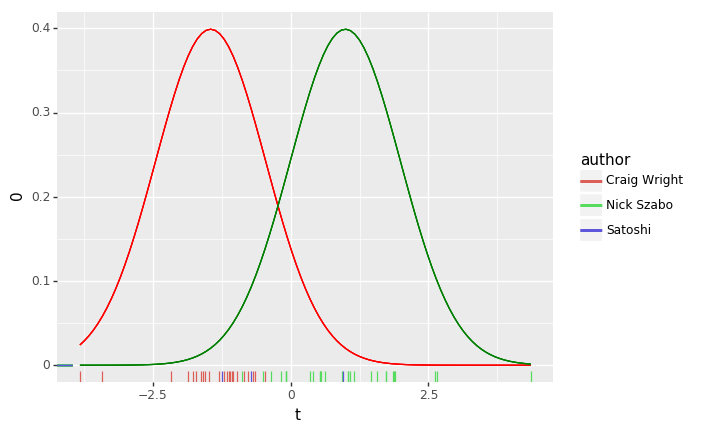

<ggplot: (-9223372036553926947)>
['Nick Szabo' 'Craig Wright' 'Craig Wright']
[[0.0444393  0.9555607 ]
 [0.90653219 0.09346781]
 [0.73215867 0.26784133]]


In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

test_author = 'Satoshi'

wrt_authors = ('Craig Wright', 'Nick Szabo')
df1 = df.filter(['doc_id', 'author', 'wrt_author', 'HC', 'rank'])\
            .pivot_table(index = ['doc_id','author'],
                         columns = 'wrt_author',
                         values = ['HC', 'rank']).HC.reset_index()

df_red = df1[df1.author.isin(wrt_authors)]

X = np.array(np.vstack([df_red[wrt_authors[0]], df_red[wrt_authors[1]]]).T)
y = np.array(df_red.author)
clf = LinearDiscriminantAnalysis()
clf.fit(X, y)  
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=True, tol=0.0001)

import plotnine
#project to discriminant component
scaling = clf.scalings_
#scaling = np.array([[1], [-1]])

df1.loc[:,'t'] = np.dot(df1.filter(wrt_authors), scaling) - np.dot(clf.intercept_ * np.ones_like(scaling).T,scaling)

#compute means and pooled variance
df_stat =  df1.groupby('author').t.agg(['var', 'count', 'mean']).loc[wrt_authors,:]
num = 0
den = 0
for c in df_stat.iterrows() :
    num += c[1]['var'] * (c[1]['count'] - 1)
    den += c[1]['count']
pooled_std = np.sqrt( num / (den - len(df_stat)))

p = (ggplot(aes(x='t', color='author', fill='author'),
            data=df1[df1.author.isin(wrt_authors) | (df1.author == test_author)]) +
     geom_rug(aes(x = 't', y = 0), position = position_jitter(height = 0)) +
     #geom_histogram(aes(y='..density..'), position="dodge", bins = 71) +
     stat_function(fun = scipy.stats.norm.pdf,
                   args = {'loc' : df_stat.loc[wrt_authors[0],'mean'],
                           'scale' : pooled_std}, color = 'red') +
     stat_function(fun = scipy.stats.norm.pdf,
                   args = {'loc' : df_stat.loc[wrt_authors[1],'mean'],
                           'scale' : pooled_std}, color = 'green')
    )         
print(p)

sm = df1[df1.author == test_author].filter(wrt_authors).values
print(clf.predict(sm))
print(clf.predict_proba(sm))

In [38]:
scipy.stats.norm.cdf(df1[df1.doc_id == 'Bitcoin_whitepaper.txt'].t,
                     loc = df_stat.loc[wrt_authors[0],'mean'], scale = pooled_std)

scipy.stats.norm.cdf(df1[df1.doc_id == 'Bitcoin_whitepaper.txt'].t,
                     loc = df_stat.loc[wrt_authors[1],'mean'], scale = pooled_std)

array([0.84692248])

/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


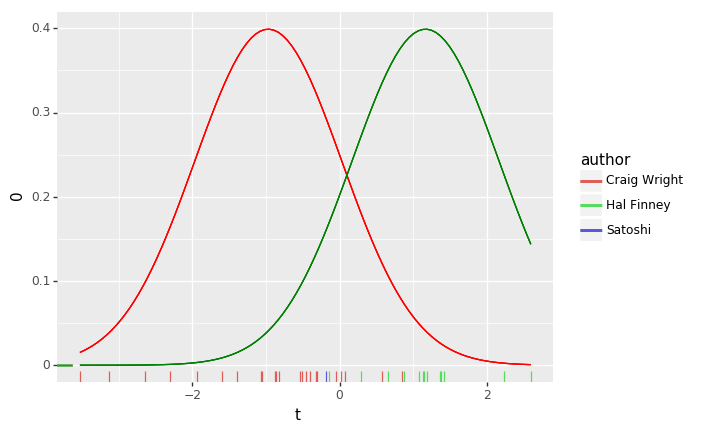

<ggplot: (-9223372036553928153)>
['Craig Wright']
[[0.76321557 0.23678443]]


/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


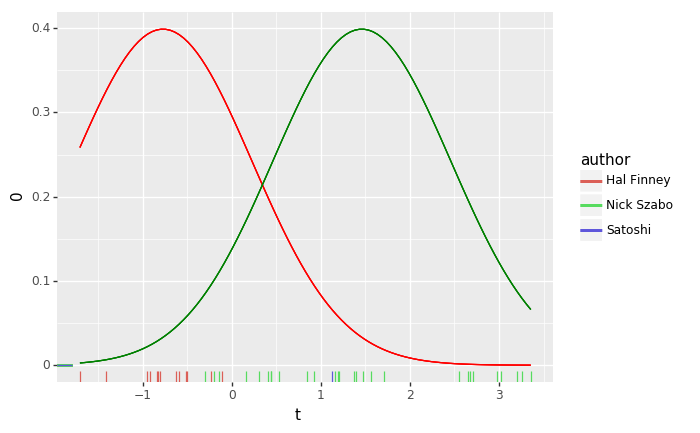

<ggplot: (-9223372036554511349)>
['Nick Szabo']
[[0.0750015 0.9249985]]


/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


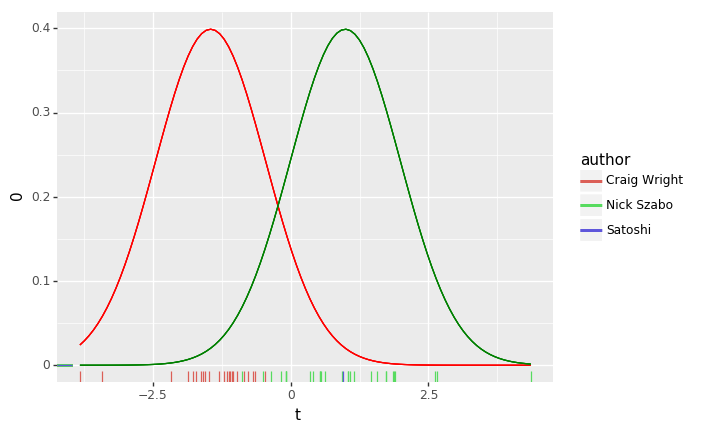

<ggplot: (-9223372036554148257)>
['Nick Szabo']
[[0.0444393 0.9555607]]


In [11]:
#LDA
import scipy
def LDA(df, wrt_authors, test_author) :
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

    df1 = df.filter(['doc_id', 'author', 'wrt_author', 'HC', 'rank'])\
                .pivot_table(index = ['doc_id','author'],
                             columns = 'wrt_author',
                             values = ['HC', 'rank']).HC.reset_index()

    df_red = df1[df1.author.isin(wrt_authors)]

    X = np.array(np.vstack([df_red[wrt_authors[0]], df_red[wrt_authors[1]]]).T)
    y = np.array(df_red.author)
    clf = LinearDiscriminantAnalysis()
    clf.fit(X, y)  
    LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                  solver='svd', store_covariance=True, tol=0.0001)

    import plotnine
    #project to discriminant component
    df1.loc[:,'t'] = np.dot(df1.filter(wrt_authors), clf.scalings_)\
                        - np.dot(clf.intercept_ * np.ones_like(scaling).T,scaling)

    #compute means and pooled variance
    df_stat =  df1.groupby('author').t.agg(['var', 'count', 'mean']).loc[wrt_authors,:]
    num = 0
    den = 0
    for c in df_stat.iterrows() :
        num += c[1]['var'] * (c[1]['count'] - 1)
        den += c[1]['count']
    pooled_std = np.sqrt( num / (den - len(df_stat)))

    p = (ggplot(aes(x='t', color='author', fill='author'),
                data=df1[df1.author.isin(wrt_authors) | (df1.author == test_author)]) +
         geom_rug(aes(x = 't', y = 0), position = position_jitter(height = 0)) +
         #geom_histogram(aes(y='..density..'), position="dodge", bins = 71) +
         stat_function(fun = scipy.stats.norm.pdf,
                       args = {'loc' : df_stat.loc[wrt_authors[0],'mean'],
                               'scale' : pooled_std}, color = 'red') +
         stat_function(fun = scipy.stats.norm.pdf,
                       args = {'loc' : df_stat.loc[wrt_authors[1],'mean'],
                               'scale' : pooled_std}, color = 'green')
        )         
    print(p)
    
    sm = df1[df1.author == test_author].filter(wrt_authors).values
    print(clf.predict(sm))
    print(clf.predict_proba(sm))

wrt_authors = ('Craig Wright', 'Hal Finney')
wrt_authors = ('Hal Finney', 'Nick Szabo')
wrt_authors = ('Craig Wright', 'Nick Szabo')


for wrt_authors in [('Craig Wright', 'Hal Finney'), ('Hal Finney', 'Nick Szabo'), ('Craig Wright', 'Nick Szabo')] :
    LDA(df[~df.doc_id.isin(['Satoshi_forum','Satoshi_emails'])], wrt_authors, test_author = 'Satoshi')    


<H2>Head-to-head comparison</H2>

In [12]:
#list of words and symbols that should not be ignored by the model 
words_to_ignore = ['27', 'https', 'typekit','subset_id','cid',
                    'fvd','af','n7', 'opentype','woff2','woff','tk',
                  '50','12','http','10','sinc','www','site','mso','com',
                   'af','font','src','url','proxima','color','microsoft','hal',
                  'san','craig','wright','satoshi','vili','lehdonvirta',
                  'bick', 'szabo', 'body', 'sans','%','ded','fb', 'php',' ',
                  'badb','?','fdb','fa', 'table', 'nav', 'linux', 'div', 
                   'saved', 'bitcoin',':',',','.','unix','text', 'xi',
                   '"','(',')',';','-','--', 'ad', 'pp', 'a', 'px', 'db', 'var', 'function', 
                   'format', 'weight', 'style', 'family', 'content', 'castronova',
                   'buttonize','net','th','kudo','activate','figure',
                   'pro','!','?', 'tree'
                  ]

Satoshi_words = ['progress', 'ahead', 'link', 'branch', 'trust', 'peer', 'block', 'or',
     'you', 'chain', 'by', 'file', 'incent', 'deficit', 'need', 'doubl', 'honest', 'one',
    'use', 'without', 'after', 'lucki', 'attack', 'in', 'network', 'privaci', 'solut', 'he',
 'transact', 'and', 'probabl', 'recipi', 'data', 'generat', 'public', 'catch', 'new', 'proof',
 'parti', 'payment', 'spend', 'next', 'broadcast', 'accept', 'propos', 'newspap', 'owner',
 'effort', 'major', 'vote', 'receiv', 'long', 'reach', 'coin', 'to', 'work', 'revers', 'input']

Satoshi_words_WFS = ['progress', 'chang', 'ahead', 'link', 'branch', 'trust', 'peer', 'block',
 'or', 'this', 'chain', 'by', 'incent', 'properti', 'still', 'deficit', 'these', 'need', 'doubl',
 'honest', 'one', 'him', 'without', 'after', 'if', 'back', 'attack', 'market', 'in', 'network',
 'privaci', 'he', 'transact', 'it', 'and', 'probabl', 'belong', 'averag', 'contain', 'page',
 'recipi', 'generat', 'extend', 'catch', 'ad', 'confirm', 'onc', 'proof', 'payment', 'spend',
 'next', 'broadcast', 'accept', 'electron', 'previous', 'right', 'owner', 'effort', 'contract',
 'major', 'receiv', 'reach', 'coin', 'to', 'work', 'revers', 'input', 'find', 'power']

In [ ]:
#load pretrained model
model_binary = pickle.load( open(path + "binary___.pkl", "rb") )

In [13]:
ds = data_proc
ds = ds[~(ds.author == 'Satoshi')]
ds = ds[~ds['type'].isin(['technical'])]
ds = ds.filter(['doc_id','text','author','type'])

ds = ds.dropna()
model_binary = AuthorshipAttributionMultiBinary(ds,
                                vocab = [w for w in vocab if w not in Satoshi_words_WFS],
#                              vocab_size = 3000,
                                global_vocab = True,
                              ngram_range = (1,1),
                             reduce_features = True,
                                words_to_ignore = words_to_ignore,
                              stbl = True)

desc = "removed Satoshi words"
pickle.dump(model_binary,open("binary_{}_{}.pkl".format(len(vocab),desc), "wb" ))


  0%|          | 0/28 [00:00<?, ?it/s]

Found 28 author-pairs
MultiBinaryAuthorModel: Creating model for Hal Finney vs Wright-Kleiman
	 Creating author-model for Wright-Kleiman using 3580 features
		found 1 documents and 3881 relevant tokens
	 Creating author-model for Hal Finney using 3580 features
		found 13 documents and 8113 relevant tokens
Reducting to 257 features
Changing vocabulary for Wright-Kleiman. Found 2700 relevant tokens


  4%|▎         | 1/28 [00:06<02:54,  6.48s/it]

Changing vocabulary for Hal Finney. Found 4699 relevant tokens
MultiBinaryAuthorModel: Creating model for Hal Finney vs Vili Lehdonvirta
	 Creating author-model for Hal Finney using 3580 features
		found 13 documents and 8113 relevant tokens
	 Creating author-model for Vili Lehdonvirta using 3580 features
		found 8 documents and 81406 relevant tokens
Reducting to 394 features
Changing vocabulary for Hal Finney. Found 4594 relevant tokens


  7%|▋         | 2/28 [00:25<04:23, 10.13s/it]

Changing vocabulary for Vili Lehdonvirta. Found 39754 relevant tokens
MultiBinaryAuthorModel: Creating model for Hal Finney vs Kleiman
	 Creating author-model for Hal Finney using 3580 features
		found 13 documents and 8113 relevant tokens
	 Creating author-model for Kleiman using 3580 features
		found 1 documents and 226433 relevant tokens
Reducting to 428 features


 11%|█         | 3/28 [00:33<04:01,  9.66s/it]

Changing vocabulary for Hal Finney. Found 5683 relevant tokens
Changing vocabulary for Kleiman. Found 139685 relevant tokens
MultiBinaryAuthorModel: Creating model for Hal Finney vs Nick Szabo
	 Creating author-model for Hal Finney using 3580 features
		found 13 documents and 8113 relevant tokens
	 Creating author-model for Nick Szabo using 3580 features
		found 28 documents and 78415 relevant tokens
Reducting to 348 features
Changing vocabulary for Hal Finney. Found 4716 relevant tokens


 14%|█▍        | 4/28 [01:12<07:18, 18.27s/it]

Changing vocabulary for Nick Szabo. Found 37379 relevant tokens
MultiBinaryAuthorModel: Creating model for Vili Lehdonvirta vs Wright-Kleiman
	 Creating author-model for Wright-Kleiman using 3580 features
		found 1 documents and 3881 relevant tokens
	 Creating author-model for Vili Lehdonvirta using 3580 features
		found 8 documents and 81406 relevant tokens
Reducting to 202 features
Changing vocabulary for Wright-Kleiman. Found 2511 relevant tokens


 18%|█▊        | 5/28 [01:21<05:55, 15.48s/it]

Changing vocabulary for Vili Lehdonvirta. Found 33908 relevant tokens
MultiBinaryAuthorModel: Creating model for Kleiman vs Wright-Kleiman
	 Creating author-model for Wright-Kleiman using 3580 features
		found 1 documents and 3881 relevant tokens
	 Creating author-model for Kleiman using 3580 features
		found 1 documents and 226433 relevant tokens


 21%|██▏       | 6/28 [01:22<04:07, 11.26s/it]

Reducting to 159 features
Changing vocabulary for Wright-Kleiman. Found 2305 relevant tokens
Changing vocabulary for Kleiman. Found 87193 relevant tokens
MultiBinaryAuthorModel: Creating model for Kleiman vs Vili Lehdonvirta
	 Creating author-model for Vili Lehdonvirta using 3580 features
		found 8 documents and 81406 relevant tokens
	 Creating author-model for Kleiman using 3580 features
		found 1 documents and 226433 relevant tokens
Reducting to 1111 features
Changing vocabulary for Vili Lehdonvirta. Found 62455 relevant tokens


 25%|██▌       | 7/28 [01:35<04:06, 11.73s/it]

Changing vocabulary for Kleiman. Found 173962 relevant tokens
MultiBinaryAuthorModel: Creating model for Kleiman vs Nick Szabo
	 Creating author-model for Kleiman using 3580 features
		found 1 documents and 226433 relevant tokens
	 Creating author-model for Nick Szabo using 3580 features
		found 28 documents and 78415 relevant tokens
Reducting to 1142 features
Changing vocabulary for Kleiman. Found 147543 relevant tokens


 29%|██▊       | 8/28 [02:16<06:53, 20.65s/it]

Changing vocabulary for Nick Szabo. Found 50564 relevant tokens
MultiBinaryAuthorModel: Creating model for Gavin Andresen vs Wright-Kleiman
	 Creating author-model for Wright-Kleiman using 3580 features
		found 1 documents and 3881 relevant tokens
	 Creating author-model for Gavin Andresen using 3580 features
		found 22 documents and 17541 relevant tokens
Reducting to 214 features
Changing vocabulary for Wright-Kleiman. Found 2844 relevant tokens


 32%|███▏      | 9/28 [02:28<05:43, 18.07s/it]

Changing vocabulary for Gavin Andresen. Found 11101 relevant tokens
MultiBinaryAuthorModel: Creating model for Gavin Andresen vs Hal Finney
	 Creating author-model for Hal Finney using 3580 features
		found 13 documents and 8113 relevant tokens
	 Creating author-model for Gavin Andresen using 3580 features
		found 22 documents and 17541 relevant tokens
Reducting to 336 features
Changing vocabulary for Hal Finney. Found 5576 relevant tokens


 36%|███▌      | 10/28 [02:47<05:30, 18.38s/it]

Changing vocabulary for Gavin Andresen. Found 12411 relevant tokens
MultiBinaryAuthorModel: Creating model for Gavin Andresen vs Vili Lehdonvirta
	 Creating author-model for Vili Lehdonvirta using 3580 features
		found 8 documents and 81406 relevant tokens
	 Creating author-model for Gavin Andresen using 3580 features
		found 22 documents and 17541 relevant tokens
Reducting to 830 features
Changing vocabulary for Vili Lehdonvirta. Found 64721 relevant tokens


 39%|███▉      | 11/28 [03:14<05:53, 20.80s/it]

Changing vocabulary for Gavin Andresen. Found 14921 relevant tokens
MultiBinaryAuthorModel: Creating model for Gavin Andresen vs Kleiman
	 Creating author-model for Kleiman using 3580 features
		found 1 documents and 226433 relevant tokens
	 Creating author-model for Gavin Andresen using 3580 features
		found 22 documents and 17541 relevant tokens
Reducting to 659 features
Changing vocabulary for Kleiman. Found 169827 relevant tokens


 43%|████▎     | 12/28 [03:30<05:09, 19.37s/it]

Changing vocabulary for Gavin Andresen. Found 14235 relevant tokens
MultiBinaryAuthorModel: Creating model for Gavin Andresen vs Nick Szabo
	 Creating author-model for Gavin Andresen using 3580 features
		found 22 documents and 17541 relevant tokens
	 Creating author-model for Nick Szabo using 3580 features
		found 28 documents and 78415 relevant tokens
Reducting to 768 features
Changing vocabulary for Gavin Andresen. Found 14143 relevant tokens


 46%|████▋     | 13/28 [04:22<07:17, 29.15s/it]

Changing vocabulary for Nick Szabo. Found 57378 relevant tokens
MultiBinaryAuthorModel: Creating model for Nick Szabo vs Wright-Kleiman
	 Creating author-model for Wright-Kleiman using 3580 features
		found 1 documents and 3881 relevant tokens
	 Creating author-model for Nick Szabo using 3580 features
		found 28 documents and 78415 relevant tokens
Reducting to 161 features
Changing vocabulary for Wright-Kleiman. Found 2303 relevant tokens


 50%|█████     | 14/28 [04:51<06:49, 29.25s/it]

Changing vocabulary for Nick Szabo. Found 25368 relevant tokens
MultiBinaryAuthorModel: Creating model for Nick Szabo vs Vili Lehdonvirta
	 Creating author-model for Vili Lehdonvirta using 3580 features
		found 8 documents and 81406 relevant tokens
	 Creating author-model for Nick Szabo using 3580 features
		found 28 documents and 78415 relevant tokens
Reducting to 1043 features
Changing vocabulary for Vili Lehdonvirta. Found 53586 relevant tokens


 54%|█████▎    | 15/28 [05:47<08:02, 37.15s/it]

Changing vocabulary for Nick Szabo. Found 51349 relevant tokens
MultiBinaryAuthorModel: Creating model for Control vs Wright-Kleiman
	 Creating author-model for Wright-Kleiman using 3580 features
		found 1 documents and 3881 relevant tokens
	 Creating author-model for Control using 3580 features
		found 16 documents and 48804 relevant tokens
Reducting to 169 features
Changing vocabulary for Wright-Kleiman. Found 2508 relevant tokens


 57%|█████▋    | 16/28 [06:02<06:05, 30.48s/it]

Changing vocabulary for Control. Found 22785 relevant tokens
MultiBinaryAuthorModel: Creating model for Control vs Hal Finney
	 Creating author-model for Hal Finney using 3580 features
		found 13 documents and 8113 relevant tokens
	 Creating author-model for Control using 3580 features
		found 16 documents and 48804 relevant tokens
Reducting to 441 features
Changing vocabulary for Hal Finney. Found 5565 relevant tokens


 61%|██████    | 17/28 [06:23<05:05, 27.75s/it]

Changing vocabulary for Control. Found 31236 relevant tokens
MultiBinaryAuthorModel: Creating model for Control vs Vili Lehdonvirta
	 Creating author-model for Vili Lehdonvirta using 3580 features
		found 8 documents and 81406 relevant tokens
	 Creating author-model for Control using 3580 features
		found 16 documents and 48804 relevant tokens
Reducting to 968 features
Changing vocabulary for Vili Lehdonvirta. Found 61228 relevant tokens


 64%|██████▍   | 18/28 [06:51<04:39, 27.90s/it]

Changing vocabulary for Control. Found 37332 relevant tokens
MultiBinaryAuthorModel: Creating model for Control vs Kleiman
	 Creating author-model for Kleiman using 3580 features
		found 1 documents and 226433 relevant tokens
	 Creating author-model for Control using 3580 features
		found 16 documents and 48804 relevant tokens
Reducting to 1087 features
Changing vocabulary for Kleiman. Found 170741 relevant tokens


 68%|██████▊   | 19/28 [07:12<03:51, 25.77s/it]

Changing vocabulary for Control. Found 37623 relevant tokens
MultiBinaryAuthorModel: Creating model for Control vs Gavin Andresen
	 Creating author-model for Gavin Andresen using 3580 features
		found 22 documents and 17541 relevant tokens
	 Creating author-model for Control using 3580 features
		found 16 documents and 48804 relevant tokens
Reducting to 686 features
Changing vocabulary for Gavin Andresen. Found 14405 relevant tokens


 71%|███████▏  | 20/28 [07:44<03:39, 27.45s/it]

Changing vocabulary for Control. Found 37273 relevant tokens
MultiBinaryAuthorModel: Creating model for Control vs Nick Szabo
	 Creating author-model for Nick Szabo using 3580 features
		found 28 documents and 78415 relevant tokens
	 Creating author-model for Control using 3580 features
		found 16 documents and 48804 relevant tokens
Reducting to 1007 features
Changing vocabulary for Nick Szabo. Found 56861 relevant tokens


 75%|███████▌  | 21/28 [08:42<04:17, 36.84s/it]

Changing vocabulary for Control. Found 36416 relevant tokens
MultiBinaryAuthorModel: Creating model for Control vs Craig Wright
	 Creating author-model for Control using 3580 features
		found 16 documents and 48804 relevant tokens
	 Creating author-model for Craig Wright using 3580 features
		found 23 documents and 38430 relevant tokens
Reducting to 811 features
Changing vocabulary for Control. Found 34931 relevant tokens


 79%|███████▊  | 22/28 [09:22<03:46, 37.77s/it]

Changing vocabulary for Craig Wright. Found 27967 relevant tokens
MultiBinaryAuthorModel: Creating model for Craig Wright vs Wright-Kleiman
	 Creating author-model for Wright-Kleiman using 3580 features
		found 1 documents and 3881 relevant tokens
	 Creating author-model for Craig Wright using 3580 features
		found 23 documents and 38430 relevant tokens
Reducting to 194 features
Changing vocabulary for Wright-Kleiman. Found 1894 relevant tokens


 82%|████████▏ | 23/28 [09:41<02:40, 32.06s/it]

Changing vocabulary for Craig Wright. Found 11258 relevant tokens
MultiBinaryAuthorModel: Creating model for Craig Wright vs Hal Finney
	 Creating author-model for Hal Finney using 3580 features
		found 13 documents and 8113 relevant tokens
	 Creating author-model for Craig Wright using 3580 features
		found 23 documents and 38430 relevant tokens
Reducting to 409 features
Changing vocabulary for Hal Finney. Found 5511 relevant tokens


 86%|████████▌ | 24/28 [10:08<02:01, 30.47s/it]

Changing vocabulary for Craig Wright. Found 23330 relevant tokens
MultiBinaryAuthorModel: Creating model for Craig Wright vs Vili Lehdonvirta
	 Creating author-model for Vili Lehdonvirta using 3580 features
		found 8 documents and 81406 relevant tokens
	 Creating author-model for Craig Wright using 3580 features
		found 23 documents and 38430 relevant tokens
Reducting to 897 features
Changing vocabulary for Vili Lehdonvirta. Found 60130 relevant tokens


 89%|████████▉ | 25/28 [10:43<01:35, 31.79s/it]

Changing vocabulary for Craig Wright. Found 28944 relevant tokens
MultiBinaryAuthorModel: Creating model for Craig Wright vs Kleiman
	 Creating author-model for Kleiman using 3580 features
		found 1 documents and 226433 relevant tokens
	 Creating author-model for Craig Wright using 3580 features
		found 23 documents and 38430 relevant tokens
Reducting to 1038 features
Changing vocabulary for Kleiman. Found 174379 relevant tokens


 93%|█████████▎| 26/28 [11:09<01:00, 30.12s/it]

Changing vocabulary for Craig Wright. Found 30300 relevant tokens
MultiBinaryAuthorModel: Creating model for Craig Wright vs Gavin Andresen
	 Creating author-model for Gavin Andresen using 3580 features
		found 22 documents and 17541 relevant tokens
	 Creating author-model for Craig Wright using 3580 features
		found 23 documents and 38430 relevant tokens
Reducting to 631 features
Changing vocabulary for Gavin Andresen. Found 13951 relevant tokens


 96%|█████████▋| 27/28 [11:46<00:32, 32.16s/it]

Changing vocabulary for Craig Wright. Found 28823 relevant tokens
MultiBinaryAuthorModel: Creating model for Craig Wright vs Nick Szabo
	 Creating author-model for Nick Szabo using 3580 features
		found 28 documents and 78415 relevant tokens
	 Creating author-model for Craig Wright using 3580 features
		found 23 documents and 38430 relevant tokens
Reducting to 925 features
Changing vocabulary for Nick Szabo. Found 57057 relevant tokens


100%|██████████| 28/28 [12:48<00:00, 41.12s/it]

Changing vocabulary for Craig Wright. Found 28664 relevant tokens


In [16]:
# predict who worte Satoshi's texts
test_data = data_proc[data_proc.author == 'Satoshi']

df1 = pd.DataFrame()
for r in test_data.iterrows() :
    pred = model_binary.predict([r[1].text], method = 'HC')
    auth = r[1].author
    df1 = df1.append({'doc_id' : r[1].doc_id,
               'author' : auth,
               'predicted' : pred,
              }, ignore_index = True)
df1

,author,doc_id,predicted
0,Satoshi,Bitcoin_whitepaper.txt,Nick Szabo
1,Satoshi,Satoshi_emails,Hal Finney
2,Satoshi,Satoshi_forum,Hal Finney


In [17]:
# information about head-to-head predicitons
sm = list(test_data[:1].text)
df1 = model_binary.predict_stats(sm, method = 'chisq')
df1

,author1,author2,margin,pred
0,Hal Finney,Wright-Kleiman,1.735430,Hal Finney
1,Hal Finney,Vili Lehdonvirta,4.872249,Hal Finney
2,Hal Finney,Kleiman,5.929512,Hal Finney
3,Hal Finney,Nick Szabo,1.161565,Nick Szabo
4,Vili Lehdonvirta,Wright-Kleiman,1.822164,Wright-Kleiman
5,Kleiman,Wright-Kleiman,1.327028,Wright-Kleiman
6,Kleiman,Vili Lehdonvirta,1.235474,Vili Lehdonvirta
7,Kleiman,Nick Szabo,7.132526,Nick Szabo
8,Gavin Andresen,Wright-Kleiman,3.329420,Wright-Kleiman
9,Gavin Andresen,Hal Finney,5.114158,Hal Finney


In [45]:
am = model_binary._AuthorPairModel[('Craig Wright', 'Hal Finney')]
am.predict_stats(sm)

,HC,chisq,chisq_pval,cosine,feat,predict,rank,wrt_author
0,20.048702,864.614966,6.553859e-133,0.086264,"[which, so, bank, cash, block, she, you, some,...","(Hal Finney, 1.2917844242495944)",1.000000,Hal Finney
1,25.898601,872.648949,3.597847e-133,0.042065,"[bank, block, you, rate, still, one, him, if, ...","(Hal Finney, 1.2917844242495944)",0.869565,Craig Wright


In [19]:
am.predict_stats(sm).feat[1]

array(['bank', 'block', 'you', 'rate', 'still', 'one', 'him', 'if',
       'attack', 'market', 'result', 'econom', 'up', 'in', 'network',
       'he', 'capit', 'get', 'keep', 'state', 'his', 'digit'],
      dtype='<U10')

In [ ]:
'bank', 'cash', 'attack', 'network', 'distribut', 'block', 'rate', 'digit', 'market', 'econom', 

In [24]:
vocab.index('econom')

992

In [63]:
# check where Satoshi is diffetent

#
ds = data_proc
ds = ds[~ds['type'].isin(['technical'])]
#ds = ds[~((ds.author == 'Satoshi') & (ds.type.isin(['emails', 'technical (forum)'])))]
ds = ds.filter(['doc_id','text','author','type'])
ds = ds.dropna()
ds = ds[ds.author.isin(['Satoshi', 'Craig Wright', 'Hal Finney', 'Nick Szabo'])]
ds.loc[:,'author'] = ds.author.apply(lambda x : x if x == 'Satoshi' else 'other')

model = AuthorshipAttributionMulti(ds,
                                   vocab = vocab, #pre-set vocabulary
                             # vocab_size = 3000,
                              #ngram_range = (1,3),
#                                words_to_ignore = words_to_ignore,
                              stbl = True)


sm = ds[ds.doc_id == 'Bitcoin_whitepaper.txt'].text.values[0]
df1 = model.predict_stats(sm)
list(df1.feat[0])

	 Creating author-model for other using 3649 features
		found 64 documents and 150881 relevant tokens
	 Creating author-model for Satoshi using 3649 features




  0%|          | 0/2 [00:00<?, ?it/s]

		found 3 documents and 13048 relevant tokens




100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

ValueError: Iterable over raw text documents expected, string object received.

In [64]:
sm = ds[ds.doc_id == 'Bitcoin_whitepaper.txt'].text.values[0]
df1 = model.predict_stats([sm])
list(df1.feat[0])

['progress',
 'chang',
 'ahead',
 'link',
 'branch',
 'trust',
 'peer',
 'block',
 'or',
 'this',
 'chain',
 'by',
 'incent',
 'properti',
 'still',
 'deficit',
 'these',
 'need',
 'doubl',
 'honest',
 'one',
 'him',
 'without',
 'after',
 'if',
 'back',
 'attack',
 'market',
 'in',
 'network',
 'privaci',
 'he',
 'transact',
 'it',
 'and',
 'probabl',
 'belong',
 'averag',
 'contain',
 'page',
 'recipi',
 'generat',
 'extend',
 'catch',
 'ad',
 'confirm',
 'onc',
 'proof',
 'payment',
 'spend',
 'next',
 'broadcast',
 'accept',
 'electron',
 'previous',
 'right',
 'owner',
 'effort',
 'contract',
 'major',
 'receiv',
 'reach',
 'coin',
 'to',
 'work',
 'revers',
 'input',
 'find',
 'power']

In [56]:
ds[ds.doc_id == 'Satoshi'].doc_id

21     Bitcoin_whitepaper.txt
114            Satoshi_emails
115             Satoshi_forum
Name: doc_id, dtype: object

In [55]:
ds = data_proc
ds = ds[~ds['type'].isin(['technical'])]
#ds = ds[~((ds.author == 'Satoshi') & (ds.type.isin(['emails', 'technical (forum)'])))]
ds = ds.filter(['doc_id','text','author','type'])
ds = ds.dropna()
ds = ds[ds.author.isin(['Satoshi', 'Craig Wright', 'Hal Finney', 'Nick Szabo'])]
ds

,doc_id,text,author,type
1,The Beauty of ECash.html,the beauti of ecash mar it occur to me that ...,Hal Finney,blog
2,Digital Cash & Privacy.html,digit cash privaci aug i agre with anonym t...,Hal Finney,blog
3,Steganography No Solution.html,steganographi no solut aug i agre with tim m...,Hal Finney,blog
4,Remailer Abuse Prevention.html,remail abus prevent mar i was ride the train...,Hal Finney,blog
5,For-Pay Remailers.html,for pay remail oct what if you could make mo...,Hal Finney,blog
6,Democracy vs. Libertarianism.html,democraci vs libertarian aug the one comment...,Hal Finney,blog
7,NetCash (First Reaction).html,first reaction to medvinski netcash propos au...,Hal Finney,blog
8,Down with Observers!.html,down with observ aug a lot of our discuss is...,Hal Finney,blog
9,Review_ Vernor Vinge’s ‘Fast Times’ _ Kurzweil...,review vernor ving s fast time septemb by h...,Hal Finney,blog
10,Politics vs Technology.html,polit vs technolog jan from mike ingl but co...,Hal Finney,blog
